# Zero‑shot Foundation Models

This notebook calls **Chronos‑2** and **TimesFM** **directly in the notebook** (no new Python files in your repo), then evaluates them vs your **base model** (`SimpleForecaster`) by **predicting past prices** with a rolling backtest and plotting:

- Actual vs Predicted (Base vs Chronos‑2 vs TimesFM)
- Absolute error over time
- Metrics: MAE / RMSE / MAPE / sMAPE

Sources for the official minimal inference examples:
- Chronos‑2 `Chronos2Pipeline.predict_df` example. citeturn1view0  
- TimesFM 2.5 torch API example (`TimesFM_2p5_200M_torch.from_pretrained`, `.compile(ForecastConfig)`, `.forecast`). citeturn2view0


In [ ]:
# Install deps (run once). If you already have them, you can skip.
# !pip install -r requirements.txt
# !pip install "chronos-forecasting>=2.0" timesfm torch accelerate yfinance pandas "pandas[pyarrow]" matplotlib

import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from pathlib import Path
import sys
import pkgutil

def find_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(12):
        if (cur / "backend").exists():
            return cur
        cur = cur.parent
    raise RuntimeError("Could not find repo root (folder containing 'backend/').")

REPO_ROOT = find_repo_root(Path.cwd())
BACKEND_PATH = REPO_ROOT / "backend"

# Put backend/ on sys.path so `data_engine` and `analytics` become top-level packages
if str(BACKEND_PATH) not in sys.path:
    sys.path.insert(0, str(BACKEND_PATH))

print("Repo root:", REPO_ROOT)
print("Backend path added:", BACKEND_PATH)

# sanity check: do we see data_engine as a package?
print("Packages under backend/:", [m.name for m in pkgutil.iter_modules([str(BACKEND_PATH)])][:20])

from data_engine.fetcher import YFinanceFetcher
from analytics.forecasting.base import SimpleForecaster

Repo root: C:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc
Backend path added: C:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\backend
Packages under backend/: ['analytics', 'app', 'core', 'data_engine', 'main', 'schemas', 'tests']


In [ ]:
# --- Pull historical prices (weekly) ---
ticker = "AAPL"          # e.g. "BTC-USD"
interval = "1wk"
period = "max"

fetcher = YFinanceFetcher()
df = fetcher.fetch_history(symbol=ticker, interval=interval, period=period)

df = df.copy()

# Make sure index is datetime (some fetchers return string index)
df.index = pd.to_datetime(df.index, errors="coerce")

# Drop any rows where datetime conversion failed
df = df[~df.index.isna()].sort_index()

prices = df["close"].astype(float) if "close" in df.columns else df["Close"].astype(float)
prices = prices.dropna()
prices.name = "close"

type(prices.index), prices.index[:3]


(pandas.DatetimeIndex,
 DatetimeIndex([          '1970-01-01 00:00:00',
                '1970-01-01 00:00:00.000000001',
                '1970-01-01 00:00:00.000000002'],
               dtype='datetime64[ns]', freq=None))

In [ ]:
# --- Helpers: metrics + rolling backtest (inline) ---
def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-12, np.nan, np.abs(y_true))
    return float(np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0)

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom < 1e-12, np.nan, denom)
    return float(np.nanmean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0)

def summarize_metrics(y_true, y_pred):
    return {
        "MAE": round(mae(y_true, y_pred), 6),
        "RMSE": round(rmse(y_true, y_pred), 6),
        "MAPE_%": round(mape(y_true, y_pred), 6),
        "sMAPE_%": round(smape(y_true, y_pred), 6),
    }

# Rolling-origin backtest: fit on history up to cutoff, predict next horizon steps
def rolling_backtest(
    series: pd.Series,
    horizon: int = 1,
    step: int = 1,
    min_train_size: int = 80,
    max_windows: int = 60,
    forecaster_fn=None,   # function(train_series, horizon) -> np.ndarray preds
):
    series = series.sort_index()
    n = len(series)
    if n < min_train_size + horizon + 1:
        raise ValueError("Not enough data for backtest with these settings.")

    dates = []
    y_true = []
    y_pred = []

    windows = 0
    for cutoff in range(min_train_size, n - horizon + 1, step):
        if windows >= max_windows:
            break
        train = series.iloc[:cutoff]
        test = series.iloc[cutoff : cutoff + horizon]

        preds = np.asarray(forecaster_fn(train, horizon), dtype=float).reshape(-1)
        if len(preds) != horizon:
            raise ValueError(f"forecaster returned {len(preds)} preds, expected {horizon}")

        dates.extend(list(test.index))
        y_true.extend(list(test.values.astype(float)))
        y_pred.extend(list(preds))
        windows += 1

    out = pd.DataFrame(
        {"date": pd.to_datetime(dates), "actual": y_true, "predicted": y_pred}
    ).sort_values("date")

    return out, summarize_metrics(out["actual"].values, out["predicted"].values)


In [ ]:
# --- Base model forecaster function (uses your existing SimpleForecaster) ---
confidence_level = 0.95

def predict_base(train: pd.Series, horizon: int) -> np.ndarray:
    m = SimpleForecaster(span=20, confidence_level=confidence_level)
    m.fit(train)
    out = m.forecast(periods=horizon)
    return np.array(out["point_forecast"], dtype=float)


In [ ]:
from chronos import Chronos2Pipeline
import pandas as pd
import numpy as np

_CHRONOS_PIPE = None

def get_chronos_pipeline(model_id="amazon/chronos-2", device_map="cpu"):
    global _CHRONOS_PIPE
    if _CHRONOS_PIPE is None:
        _CHRONOS_PIPE = Chronos2Pipeline.from_pretrained(model_id, device_map=device_map)
    return _CHRONOS_PIPE

def predict_chronos2(
    train: pd.Series,
    horizon: int,
    model_id="amazon/chronos-2",
    device_map="cpu",
    quantiles=(0.1, 0.5, 0.9),
    batch_size=256,
    context_length=None,   # set e.g. 512/1024 to cap context
):
    pipe = get_chronos_pipeline(model_id=model_id, device_map=device_map)

    # IMPORTANT: match the pipeline defaults: item_id / timestamp / target
    df = pd.DataFrame(
        {
            "item_id": "series",
            "timestamp": pd.to_datetime(train.index),
            "target": train.values.astype(float),
        }
    )

    # Keep quantiles valid + sorted
    q = sorted({float(x) for x in quantiles if 0 < float(x) < 1})
    if not q:
        q = [0.5]

    pred_df = pipe.predict_df(
        df,
        prediction_length=int(horizon),
        quantile_levels=q,
        id_column="item_id",
        timestamp_column="timestamp",
        target="target",
        batch_size=int(batch_size),
        context_length=context_length,
        validate_inputs=True,
        # NOTE: do NOT pass num_samples here (your error)
        # If your version supports sampling, it'd be via **predict_kwargs,
        # but we keep it minimal for reliability.
    ).sort_values("timestamp")

    # Use median quantile if present; else fallback
    if "0.5" in pred_df.columns:
        return pred_df["0.5"].astype(float).to_numpy()

    # Some versions return quantile columns as floats, not strings
    if 0.5 in pred_df.columns:
        return pred_df[0.5].astype(float).to_numpy()

    # Or point predictions
    if "predictions" in pred_df.columns:
        return pred_df["predictions"].astype(float).to_numpy()

    raise RuntimeError(f"Unexpected Chronos output columns: {list(pred_df.columns)}")

In [ ]:
# --- TimesFM forecaster function (direct call, no new project files) ---
# Official README example shows:
# model = timesfm.TimesFM_2p5_200M_torch.from_pretrained(...)
# model.compile(timesfm.ForecastConfig(...))
# point_forecast, quantile_forecast = model.forecast(horizon=..., inputs=[...])
# citeturn2view0

import torch
import timesfm

torch.set_float32_matmul_precision("high")

_TIMESFM_MODEL = None

def get_timesfm_model(
    hf_id="google/timesfm-2.5-200m-pytorch",
    max_context=1024,
    max_horizon=256,
):
    global _TIMESFM_MODEL
    if _TIMESFM_MODEL is None:
        _TIMESFM_MODEL = timesfm.TimesFM_2p5_200M_torch.from_pretrained(hf_id)
        _TIMESFM_MODEL.compile(
            timesfm.ForecastConfig(
                max_context=int(max_context),
                max_horizon=int(max_horizon),
                normalize_inputs=True,
                use_continuous_quantile_head=True,
                force_flip_invariance=True,
                infer_is_positive=True,
                fix_quantile_crossing=True,
            )
        )
    return _TIMESFM_MODEL

def predict_timesfm(
    train: pd.Series,
    horizon: int,
    hf_id="google/timesfm-2.5-200m-pytorch",
    max_context=1024,
):
    model = get_timesfm_model(hf_id=hf_id, max_context=max_context, max_horizon=max(256, horizon))
    # TimesFM API expects a list of 1D numpy arrays (one per series)
    x = train.values.astype(np.float32)
    # Optionally trim context
    if len(x) > max_context:
        x = x[-max_context:]
    point_forecast, quantile_forecast = model.forecast(horizon=int(horizon), inputs=[x])
    # point_forecast shape: (n_series, horizon)
    return np.asarray(point_forecast[0], dtype=float)


ModuleNotFoundError: No module named 'timesfm'

In [ ]:
# --- Run backtests ---
horizon = 1
min_train_size = 80
max_windows = 60

base_df, base_metrics = rolling_backtest(
    prices, horizon=horizon, min_train_size=min_train_size, max_windows=max_windows, forecaster_fn=predict_base
)

chronos_df, chronos_metrics = rolling_backtest(
    prices,
    horizon=horizon,
    min_train_size=min_train_size,
    max_windows=max_windows,
    forecaster_fn=lambda tr, h: predict_chronos2(tr, h, device_map="cpu", quantiles=(0.1,0.5,0.9))
)

#timesfm_df, timesfm_metrics = rolling_backtest(
#    prices, horizon=horizon, min_train_size=min_train_size, max_windows=max_windows,
#    forecaster_fn=lambda tr, h: predict_timesfm(tr, h)
#)

metrics = pd.DataFrame(
    [base_metrics, chronos_metrics],#, timesfm_metrics],
    index=["Base (SimpleForecaster)", "Foundation (Chronos-2)"],#, "Foundation (TimesFM)"],
)
display(metrics)


c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\chronos\chronos2\dataset.py:89: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  task_target = torch.from_numpy(task_target)


,MAE,RMSE,MAPE_%,sMAPE_%
Base (SimpleForecaster),0.025187,0.029656,21.146896,23.015720
Foundation (Chronos-2),0.008080,0.010283,7.177867,7.324872


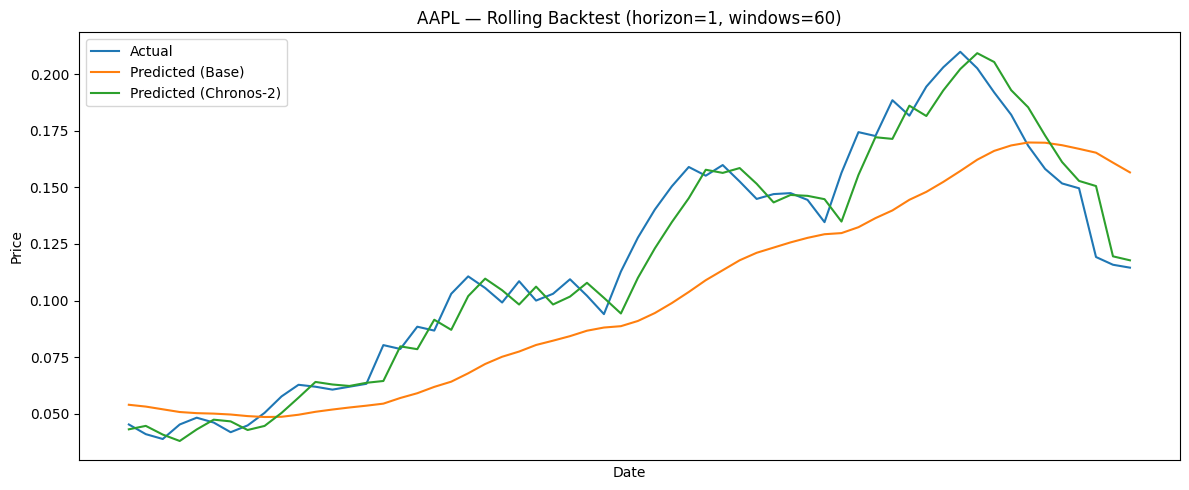

,date,actual,pred_base,pred_chronos2
55,1970-01-01 00:00:00.000000135,0.151721,0.1686,0.161167
56,1970-01-01 00:00:00.000000136,0.149584,0.1670,0.152834
57,1970-01-01 00:00:00.000000137,0.119239,0.1653,0.150568
58,1970-01-01 00:00:00.000000138,0.115821,0.1609,0.119537
59,1970-01-01 00:00:00.000000139,0.114538,0.1566,0.117784


In [ ]:
# --- Plot Actual vs Predicted (all models) ---
# Align by date (inner join)
m = base_df.rename(columns={"predicted":"pred_base"}).merge(
    chronos_df[["date","predicted"]].rename(columns={"predicted":"pred_chronos2"}),
    on="date",
    how="inner"
).sort_values("date")#.merge(
#    timesfm_df[["date","predicted"]].rename(columns={"predicted":"pred_timesfm"}),
#    on="date",
#    how="inner"
#)


plt.figure(figsize=(12, 5))
plt.plot(m["date"], m["actual"], label="Actual")
plt.plot(m["date"], m["pred_base"], label="Predicted (Base)")
plt.plot(m["date"], m["pred_chronos2"], label="Predicted (Chronos-2)")
#plt.plot(m["date"], m["pred_timesfm"], label="Predicted (TimesFM)")
plt.title(f"{ticker} — Rolling Backtest (horizon={horizon}, windows={len(m)})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

display(m.tail())


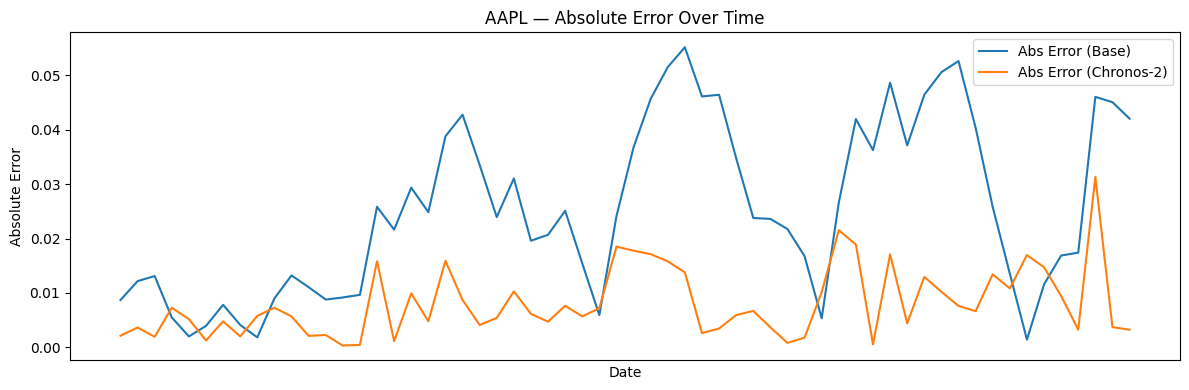

In [ ]:
# --- Plot Absolute Error Over Time ---
m["abs_err_base"] = (m["actual"] - m["pred_base"]).abs()
m["abs_err_chronos2"] = (m["actual"] - m["pred_chronos2"]).abs()
#m["abs_err_timesfm"] = (m["actual"] - m["pred_timesfm"]).abs()

plt.figure(figsize=(12, 4))
plt.plot(m["date"], m["abs_err_base"], label="Abs Error (Base)")
plt.plot(m["date"], m["abs_err_chronos2"], label="Abs Error (Chronos-2)")
#plt.plot(m["date"], m["abs_err_timesfm"], label="Abs Error (TimesFM)")
plt.title(f"{ticker} — Absolute Error Over Time")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# --- Quick tips ---
# 1) If you have a GPU, set:
#    - Chronos-2: device_map="cuda"
# 2) If TimesFM runs out of RAM, reduce max_context (e.g., 512) and/or max_windows.
# 3) If you want multi-step evaluation, set horizon = 4 (but it will run slower).
